In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn import metrics
import gc
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

pd.set_option('display.max_columns', 200)

In [2]:
#autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2
#include matplotlib graphs in the notebook
%matplotlib inline

In [3]:
#specify where the data is located
PATH = "C:\\Users\\Agata\\fastai\\courses\\ml1\\data\\santander\\"

In [4]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [5]:
print(f'Number of rows and columns in train set {train.shape}')
print(f'Number of rows and columns in test set {test.shape}')

Number of rows and columns in train set (200000, 202)
Number of rows and columns in test set (200000, 201)


In [6]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train ['target']

In [7]:
df = train[features]
y = train ['target']

In [1]:
#train.info

## Unbalanced target variable
Up-sample Minority Class

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

I will resample with replacement.


Next, we'll create a new DataFrame with an up-sampled minority class. Here are the steps:

   1. First, we'll separate observations from each class into different DataFrames.
   2. Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
   3. Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.


In [8]:
print(train['target'].value_counts())

0    179902
1     20098
Name: target, dtype: int64


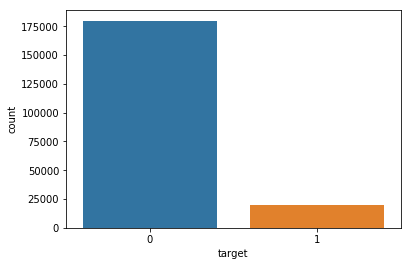

In [14]:
import seaborn as sns
sns.countplot(train['target'])

In [10]:
print("Percentage of target variables with value of 1: {}%".format(100 * train["target"].value_counts()[1]/train.shape[0]))

Percentage of target variables with value of 1: 10.049%


In [44]:
from sklearn.utils import resample

In [45]:
# Separate majority and minority classes
df_majority = train[train['target']==0]
df_minority = train[train['target']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=179902,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['target'].value_counts()

1    179902
0    179902
Name: target, dtype: int64

In [18]:
len(df_upsampled)

359804

### Random Froest

validation set

In [19]:
y = df_upsampled['target']
df = df_upsampled[features]

In [ ]:
df = train[features]
y = train ['target']

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(287843, 200) (287843,)
(71961, 200) (71961,)


In [22]:
# print rmse for train and validation set, r2 for train and validation set and oob score if there is one calculated
def print_score(m):
    res = [ metrics.roc_auc_score(m.predict(X_train), y_train),  metrics.roc_auc_score(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [23]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9999513354271151, 0.9967187020245944, 0.9999513623746278, 0.9967204457970289]


### bayesian optimisation for random forest

In [24]:
def RF_bayesian(
    min_samples_leaf, 
    max_features):
    
    param = {
        'n_estimators': 50, 
        'min_samples_leaf': int(min_samples_leaf), 
        'max_features': int(max_features),
        'n_jobs': -1,
        'class_weight': 'balanced'
    }  
    #assert type(min_samples_leaf) == int
    #assert type(max_features) == int
    
    
    m = RandomForestClassifier(**param)   
    m.fit(X_train, y_train)

    score = metrics.roc_auc_score(m.predict(X_valid), y_valid)
    return score

In [121]:
import math
math.sqrt(len(features))
math.log2(len(features))
len(features)

200

In [25]:
bounds_RF = {
    #'n_estimators':n_estimators, 
    'min_samples_leaf': (5,50), 
    'max_features': (5,100)
}

In [26]:
# BayesianOptimization object
RF_BO = BayesianOptimization(RF_bayesian, bounds_RF, random_state=13)

In [27]:
print(RF_BO.space.keys)

['max_features', 'min_samples_leaf']


In [28]:
init_points = 5
n_iter = 5

In [29]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    RF_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | max_fe... | min_sa... |
-------------------------------------------------
|  1        |  0.9817   |  78.88    |  15.69    |
|  2        |  0.9306   |  83.31    |  48.46    |
|  3        |  0.9655   |  97.4     |  25.41    |
|  4        |  0.9446   |  62.86    |  39.9     |
|  5        |  0.9467   |  65.95    |  37.49    |
|  6        |  0.9977   |  5.3      |  5.146    |
|  7        |  0.9959   |  51.4     |  5.008    |
|  8        |  0.9949   |  99.31    |  5.003    |
|  9        |  0.9975   |  5.298    |  5.004    |
|  10       |  0.9976   |  5.73     |  5.001    |


### RF using LGB library


In [10]:
df = train[features]
y = train ['target']

In [11]:
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train, target))[0]

In [35]:
def RF_bayesian2(
    num_leaves,
    colsample_bytree,
    min_child_weight,
    reg_alpha,
    min_child_samples, 
    feature_fraction,
    reg_lambda):
    
    param = {
        'boosting_type':"rf",
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': int(num_leaves),
        #colsample_bytree - a fraction of features to consider when fitting a tree
        'colsample_bytree': int(colsample_bytree),
        'n_estimators':100,
        'min_child_weight': min_child_weight , # minimal sum hessian in one leaf, regularisation parameter
        'min_child_samples': int(min_child_samples), # specifies the minimum samples per leaf node
        #bagging_fraction,  default =1.0,  type = double,  aliases:sub_row,subsample,bagging,  
        #con-straints:0.0 < bagging_fraction <= 1.0
        #–like feature_fraction, but this will randomly select part of data without resampling
        #–can be used to speed up training–can be used to deal with over-fitting–  ]
        #Note: to enable bagging,bagging_freqshould be set to a non zero value as well
         'subsample':.632, # Standard RF bagging fraction
        #bagging_freq, default =0, type = int, aliases:subsample_freq–frequency for bagging
         'subsample_freq':1,
         'min_split_gain':0,
         'reg_alpha':reg_alpha, # Hard L1 regularization =lambda_l1
         'reg_lambda':reg_lambda, #lambda_l2
         'n_jobs':-1,
         'is_unbalance': True,
         'feature_fraction': feature_fraction
    }  
    
    xg_train = lgb.Dataset(train.iloc[bayesian_tr_index][features].values,
                           #label=train.iloc[bayesian_tr_index]['target'].values,
                           label=target.iloc[bayesian_tr_index].values,
                           feature_name=features,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train.iloc[bayesian_val_index][features].values,
                           label=train.iloc[bayesian_val_index]['target'].values,
                           feature_name=features,
                           free_raw_data = False
                           )   

    #xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50
    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    #num_iteration
    predictions = clf.predict(train.iloc[bayesian_val_index][features].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(train.iloc[bayesian_val_index]['target'].values, predictions)
    
    return score

In [37]:
bounds_RF = {
    'num_leaves': (20, 50), #  Maximum  tree  leaves  for  baselearners, default=31
    'colsample_bytree': (0.6, 0.85), # colsample_bytree - a fraction of features to consider when fitting a tree
    'min_child_weight': (0.001, 25), # minimal sum hessian in one leaf
    'reg_alpha': (0, 0.7),
    'reg_lambda': (0, 0.5),
    'min_child_samples': (30, 100), # specifies the minimum samples per leaf node
    'feature_fraction': (0.2, 0.5) #feature sub-sampling
}

In [38]:
# BayesianOptimization object
RF_BO = BayesianOptimization(RF_bayesian2, bounds_RF)

In [39]:
print(RF_BO.space.keys)

['colsample_bytree', 'feature_fraction', 'min_child_samples', 'min_child_weight', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [40]:
init_points = 5
n_iter = 100

In [41]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    RF_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... | featur... | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.816161
|  1        |  0.8162   |  0.8219   |  0.2355   |  75.99    |  23.85    |  31.33    |  0.09803  |  0.09443  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.803621
|  2        |  0.8036   |  0.6901   |  0.3238   |  88.1     |  6.738    |  39.29    |  0.2694   |  0.08829  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.812335
|  3     

|  25       |  0.8024   |  0.7626   |  0.349    |  44.05    |  13.76    |  49.95    |  0.02139  |  0.1982   |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.807313
|  26       |  0.8073   |  0.7286   |  0.2288   |  86.04    |  14.2     |  20.52    |  0.1418   |  0.0183   |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.814368
|  27       |  0.8144   |  0.6718   |  0.2644   |  30.14    |  24.95    |  38.92    |  0.6253   |  0.08536  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.822637
|  28       |  0.8226   |  0.7235   |  0.258    |  87.31    |  0.1731   |  49.84    |  0.01054  |  0.222    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.807303


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.827922
|  51       |  0.8279   |  0.8144   |  0.2097   |  67.75    |  12.36    |  42.31    |  0.6151   |  0.03387  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.828091
|  52       |  0.8281   |  0.6759   |  0.2216   |  56.72    |  0.3881   |  49.54    |  0.6917   |  0.01631  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.832359
|  53       |  0.8324   |  0.8308   |  0.2025   |  75.11    |  13.9     |  48.68    |  0.3218   |  0.01119  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.8292
|  54       |  0.8292   |  0.8318   |  0.2149   |  77.85    |  5.511    |  49.88    |  0.5637   |  0.08528  |
Tr

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.829009
|  77       |  0.829    |  0.7763   |  0.2068   |  43.99    |  24.65    |  49.26    |  0.2036   |  0.4355   |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.833279
|  78       |  0.8333   |  0.7579   |  0.2044   |  87.84    |  18.45    |  48.82    |  0.6976   |  0.000593 |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.833499
|  79       |  0.8335   |  0.7709   |  0.2006   |  88.87    |  17.04    |  49.92    |  0.3864   |  0.2539   |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.833063
|  80       |  0.8331   |  0.846    |  0.2032   |  91.66    |  18.97    |  48.43    |  0.3395   |  0.04205  |


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.833003
|  103      |  0.833    |  0.847    |  0.202    |  94.96    |  1.616    |  48.45    |  0.3139   |  0.166    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.813566
|  104      |  0.8136   |  0.7255   |  0.2034   |  42.37    |  13.93    |  20.48    |  0.6924   |  0.02184  |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.831304
|  105      |  0.8313   |  0.8391   |  0.2015   |  95.18    |  24.19    |  43.51    |  0.005699 |  0.1771   |


In [31]:
# parametres tested and the corresponding auc
for i, res in enumerate(RF_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7451345285733285, 'params': {'colsample_bytree': 0.2871684576128982, 'feature_fraction': 0.6594180235308411, 'min_child_samples': 44.8844746872853, 'min_child_weight': 2.064219296736871, 'num_leaves': 26.2304720973986, 'reg_alpha': 0.25164377471522836}}
Iteration 1: 
	{'target': 0.7778843273744026, 'params': {'colsample_bytree': 0.6990740474974501, 'feature_fraction': 0.41569701705075285, 'min_child_samples': 13.738249162611563, 'min_child_weight': 4.208431877067897, 'num_leaves': 31.066097599094643, 'reg_alpha': 0.1214976107073582}}
Iteration 2: 
	{'target': 0.7725947185590752, 'params': {'colsample_bytree': 0.5473833495573677, 'feature_fraction': 0.5522692232873746, 'min_child_samples': 34.401867540028874, 'min_child_weight': 1.6446957936570799, 'num_leaves': 49.93481956085077, 'reg_alpha': 0.11638075625353089}}
Iteration 3: 
	{'target': 0.7772222349440062, 'params': {'colsample_bytree': 0.4216833955519628, 'feature_fraction': 0.47677273112769414, 'min_chi

In [42]:
#what is the max auc that we've got
RF_BO.max['target']

0.8342287602699943

In [43]:
#parametrs that have been found
RF_BO.max['params']

{'colsample_bytree': 0.8499999999669705,
 'feature_fraction': 0.20000000681901517,
 'min_child_samples': 99.99999999511712,
 'min_child_weight': 24.99999999764361,
 'num_leaves': 49.99999999918492,
 'reg_alpha': 0.6999999999075175,
 'reg_lambda': 3.16496075971691e-08}

### RF the best model

In [46]:
y = df_upsampled['target']
df = df_upsampled[features]

In [49]:
param = {
        'boosting_type':"rf",
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': int(RF_BO.max['params']['num_leaves']),
        'colsample_bytree': int(RF_BO.max['params']['colsample_bytree']),
        'n_estimators':500,
        'min_child_weight': RF_BO.max['params']['min_child_weight'] , 
        'min_child_samples': int(RF_BO.max['params']['min_child_samples']), 
         'subsample':.632, 
         'subsample_freq':1,
         'min_split_gain':0,
         'reg_alpha':RF_BO.max['params']['reg_alpha'], 
         'reg_lambda':RF_BO.max['params']['reg_lambda'], 
         'n_jobs':-1,
         'is_unbalance': True,
         'feature_fraction': RF_BO.max['params']['feature_fraction']
}

In [48]:
xg_train = lgb.Dataset(df.values,
                           #label=train.iloc[bayesian_tr_index]['target'].values,
                           label=y.values,
                           feature_name=features,
                           free_raw_data = False
                           )


In [50]:
num_round = 5000
clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_train], verbose_eval=250, early_stopping_rounds = 50)
    
predictions = clf.predict(df.values, num_iteration=clf.best_iteration)   
score = metrics.roc_auc_score(y.values, predictions)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[250]	training's auc: 0.873516
Early stopping, best iteration is:
[274]	training's auc: 0.874126


In [54]:
predictions = clf.predict(test.drop('ID_code', axis=1), num_iteration=clf.best_iteration) 

In [55]:
sub_df = pd.DataFrame({"ID_code": test.ID_code.values})
sub_df["target"] = predictions
sub_df[:10]

,ID_code,target
0,test_0,0.540942
1,test_1,0.517759
2,test_2,0.516442
3,test_3,0.468894
4,test_4,0.442610
5,test_5,0.380616
6,test_6,0.436250
7,test_7,0.505666
8,test_8,0.383355
9,test_9,0.412262


In [57]:
sub_df.to_csv(f'{PATH}submission.csv', index=False)

### LGB

StratifiedKFold -> returns an object with indices to split data in train/val sets; preserves the percentage of samples in each class

split method -> Generate indices to split data into training and test set.

list -> we transform a generator object into a list

we take only the first element (the first split)

so it is equivalent to jest spliting the data in half.. one half is a train set and the other is the validation set

In [8]:
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train, target))[0]

We will try to tune:

**num_leaves**

**min_data_in_leaf**

**learning_rate**

**min_sum_hessian_in_leaf** - minimal sum hessian in one leaf. Likemin_data_in_leaf, it can be used to deal with over-fitting

**feature_fraction** - feature sub-sampling

**lambda_l1**

**lambda_l2**

**min_gain_to_split**

**max_depth**

max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1

In [89]:
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    #learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    bagging_fraction,
    bagging_freq):

    param = {
        'num_leaves': int(num_leaves),
        'n_estimators': 100,
        'min_data_in_leaf': int(min_data_in_leaf),
        'learning_rate': 0.07,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': bagging_freq,
        "bagging_fraction": bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': -1,
        #save_binary - iftrue, LightGBM will save the dataset (including validation data) to a binary file.  
        #This speed ups thedata loading for the next time
        'save_binary': True, 
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        #is_unbalance - used only inbinaryapplication; set this totrue if training data are unbalanced
        'is_unbalance': True,
        #boost_from_average - adjusts initial score to the mean of labels for faster convergence
        'boost_from_average': False,  
        "tree_learner": "serial",
        'bagging_freq': int(bagging_freq)
    }    
    
    
    xg_train = lgb.Dataset(train.iloc[bayesian_tr_index][features].values,
                           #label=train.iloc[bayesian_tr_index]['target'].values,
                           label=target.iloc[bayesian_tr_index].values,
                           feature_name=features,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train.iloc[bayesian_val_index][features].values,
                           label=train.iloc[bayesian_val_index]['target'].values,
                           feature_name=features,
                           free_raw_data = False
                           )   

    #xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50
    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    #num_iteration
    predictions = clf.predict(train.iloc[bayesian_val_index][features].values, num_iteration=clf.best_iteration)   
    
    score = metrics.roc_auc_score(train.iloc[bayesian_val_index]['target'].values, predictions)
    
    return score

In [90]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (30, 120),  
    #'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.001, 20),    
    'feature_fraction': (0.03, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'bagging_fraction':(0.2, 0.6),
    "bagging_freq":(3,10)
}

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [91]:
# BayesianOptimization object
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

In [92]:
#the parameters we are gaoing to optimise
print(LGB_BO.space.keys)

['bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']



    init_points: How many initial random runs of random exploration we want to perform. In our case LGB_bayesian will be called n_iter times.
    n_iter: How many runs of bayesian optimization we want to perform after number of init_points runs.


In [93]:
init_points = 5
n_iter = 100

In [94]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.78505
|  1        |  0.7851   |  0.5111   |  4.663    |  0.4174   |  4.829    |  4.863    |  70.81    |  0.609    |  15.51    |  14.62    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.814066
|  2        |  0.8141   |  0.4888   |  3.245    |  0.1703   |  0.2926   |  4.285    |  63.56    |  0.6798   |  5.126    |  10.21    |
Training until validation scores don't improve for 50 r

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.849521
|  23       |  0.8495   |  0.6      |  10.0     |  0.03     |  0.0      |  0.0      |  62.55    |  1.0      |  20.0     |  20.0     |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.835008
|  24       |  0.835    |  0.6      |  3.0      |  0.03     |  0.0      |  5.0      |  105.5    |  0.0      |  20.0     |  5.0      |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.835053
|  25       |  0.8351   |  0.6      |  9.358    |  0.03     |  3.584    |  0.0      |  70.19    |  1.0      |  1e-05    |  5.282    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.841185
|  26       |  0.8412   |  0.6      | 

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.850734
|  46       |  0.8507   |  0.6      |  10.0     |  0.03     |  0.0      |  5.0      |  97.95    |  1.0      |  1.002e-0 |  19.29    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.849684
|  47       |  0.8497   |  0.6      |  7.781    |  0.03     |  0.6049   |  5.0      |  119.3    |  0.9773   |  10.6     |  10.55    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.851246
|  48       |  0.8512   |  0.6      |  3.975    |  0.03     |  2.789    |  0.4504   |  47.53    |  0.6563   |  19.74    |  19.89    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.851729
|  49       |  0.8517   |  0.6      | 

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.853914
|  69       |  0.8539   |  0.5401   |  3.087    |  0.0941   |  0.6851   |  0.5551   |  38.01    |  0.5801   |  16.75    |  19.36    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.856095
|  70       |  0.8561   |  0.3928   |  3.599    |  0.04373  |  0.7207   |  4.532    |  41.81    |  0.9988   |  19.02    |  18.9     |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.863252
|  71       |  0.8633   |  0.5877   |  9.611    |  0.06521  |  4.713    |  0.8566   |  31.58    |  0.8832   |  5.781    |  19.42    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.847195
|  72       |  0.8472   |  0.6      |  

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.844943
|  92       |  0.8449   |  0.351    |  4.672    |  0.03969  |  4.93     |  4.991    |  116.3    |  0.7158   |  5.41     |  6.045    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862834
|  93       |  0.8628   |  0.3752   |  3.15     |  0.06603  |  0.2695   |  3.828    |  65.79    |  0.6582   |  19.87    |  19.58    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.854895
|  94       |  0.8549   |  0.5064   |  4.837    |  0.03728  |  0.6861   |  0.2673   |  35.89    |  0.6711   |  1.393    |  19.86    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.859114
|  95       |  0.8591   |  0.59     | 

In [1]:
# parametres tested and the corresponding auc
#for i, res in enumerate(LGB_BO.res):
#    print("Iteration {}: \n\t{}".format(i, res))

In [95]:
#what is the max auc that we've got
LGB_BO.max['target']

0.8635832357546565

In [96]:
#parametrs the have benn found
LGB_BO.max['params']

{'bagging_fraction': 0.5753998339245148,
 'bagging_freq': 6.408385370603334,
 'feature_fraction': 0.06643110789635034,
 'lambda_l1': 3.0552634836492882,
 'lambda_l2': 0.11888476928475944,
 'min_data_in_leaf': 119.43637202941925,
 'min_gain_to_split': 0.9804715370021717,
 'min_sum_hessian_in_leaf': 8.89962183049432,
 'num_leaves': 19.519708853802882}

0.89:
{'feature_fraction': 0.0725311213806508,
 'lambda_l1': 4.778909939998174,
 'lambda_l2': 3.220122059503974,
 'learning_rate': 0.07663544326133201,
 'max_depth': 14.99504485809263,
 'min_data_in_leaf': 6.071757005556453,
 'min_gain_to_split': 0.4634735801572327,
 'min_sum_hessian_in_leaf': 0.007510919138894667,
 'num_leaves': 5.001626877554514}

### LGB optimisation with cross validation

In [16]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          learning_rate
         ):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    #oof - out of fold
    oof = np.zeros(train.shape[0])
    
    #enumerate - allows us to loop over something and have an automatic counter

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx])
    
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective': 'binary',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction,
            "bagging_seed": 11,
            "metric": 'auc',
            "lambda_l1": lambda_l1,
            "verbosity": -1,
            'is_unbalance': True,
            'save_binary': True,
            'learning_rate':learning_rate
        }
        
        
    
        
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()      
        
    return metrics.roc_auc_score(oof, target)

In [17]:
# Bounded region of parameter space
bounds_LGB = {
     
    'learning_rate': (0.01, 0.3),   
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6)
}

In [18]:
# BayesianOptimization object
LGB_BO = BayesianOptimization(LGB_CV, bounds_LGB, random_state=13)

In [19]:
#the parameters we are gaoing to optimise
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'lambda_l1', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'num_leaves']


In [20]:
init_points = 5
n_iter = 20

In [2]:
#to do
#print('-' * 130)

#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')
#    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

### LGB model

In [ ]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), # remember to int here
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), # remember to int here
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), # remember to int here
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [37]:
nfold = 5

In [38]:
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

In [ ]:
#
oof = np.zeros(len(train))
predictions = np.zeros((len(test),nfold))

i = 1
for train_index, valid_index in skf.split(train, target.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(train_df.iloc[train_index][predictors].values,
                           label=train_df.iloc[train_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train_df.iloc[valid_index][predictors].values,
                           label=train_df.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param_lgb, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    predictions[:,i-1] += clf.predict(test_df[predictors], num_iteration=clf.best_iteration)
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(train_df.target.values, oof)))

### Rank averaging

In [ ]:
#todo
print("Rank averaging on", nfold, "fold predictions")
rank_predictions = np.zeros((predictions.shape[0],1))
for i in range(nfold):
    rank_predictions[:, 0] = np.add(rank_predictions[:, 0], rankdata(predictions[:, i].reshape(-1,1))/rank_predictions.shape[0]) 

rank_predictions /= nfold

### Submission

In [118]:
sample_submission=pd.read_csv(f'{PATH}sample_submission.csv')

In [119]:
sample_submission.head(5)

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [ ]:
#todo
sub_df = pd.DataFrame({"ID_code": test.ID_code.values})
sub_df["target"] = rank_predictions
sub_df[:10]